In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install git+https://github.com/google/jax-cfd

!conda env create -f environment.yml

!conda activate sda

!pip install -e "/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/"

!pip uninstall -y sda

!pip install "/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/"

!pip install zuko

!pip install POT

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/google/jax-cfd to /tmp/pip-req-build-vhtiyq79
  Running command git clone --filter=blob:none --quiet https://github.com/google/jax-cfd /tmp/pip-req-build-vhtiyq79
  Resolved https://github.com/google/jax-cfd to commit 59f6d415d3abd66ca2c1728396c7622b41d1ac66
  Preparing metadata (setup.py) ... done
/bin/bash: line 1: conda: command not found
/bin/bash: line 1: conda: command not found
Obtaining file:///content/drive/MyDrive/FISE%203A/UE_F_Computational%20Imaging/Project/sda-master
  Preparing metadata (setup.py) ... done
  Attempting uninstall: sda
    Found existing installation: sda 1.0.0
    Uninstalling sda-1.0.0:
      Successfully uninstalled sda-1.0.0
  Running setup.py develop for sda
Found existing installation: sda 1.0.0
Uninstalling sda-1.0.0:
  Successfully uninstalled sda-1.0.0
Processing ./drive/MyDrive/FISE 3A/UE_F_

ERROR: Operation cancelled by user
^C
^C


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import sys

sda_path = r"/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/sda"
sys.path.append(sda_path)

print(sys.path)

import h5py
import numpy as np
import torch

experiments_path = r"/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments"
sys.path.append(experiments_path)

kolmogorov_path = os.path.join(experiments_path, 'kolmogorov')
sys.path.append(kolmogorov_path)

print(sys.path)

from sda.mcs import *
from sda.score import *
from sda.utils import *

from kolmogorov.utils import *
# from utils import *

chain = make_chain()

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/sda']
['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/sda', '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments', '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments/kolmogorov']


## Score network

In [ ]:
# score = load_score(PATH / 'runs/glorious-flower-3_zw7vkqm0/state.pth')  # k=1, width=32
# score = load_score(PATH / 'runs/azure-wave-2_9ry6v9ul/state.pth')  # k=1, width=64
# score = load_score(PATH / 'runs/bumbling-monkey-6_3m4uyfe8/state.pth')  # k=1, width=96
# score = load_score(PATH / 'runs/graceful-snowball-8_i6pzpnst/state.pth')  # k=2, width=96
from pathlib import Path
score = load_score(Path('/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments/kolmogorov/runs/None_xgjapgm6/state.pth'))

## Circle

In [ ]:
def circle():
    x = torch.linspace(-1, 1, 64)
    x = torch.cartesian_prod(x, x)

    dist = x.square().sum(dim=-1).reshape(64, 64)
    mask = torch.logical_and(0.4 < dist, dist < 0.6)

    return mask

# mask = circle().cuda()
mask = circle()

def A(x):
    return chain.vorticity(x[..., -1, :, :, :]) * mask

sde = VPSDE(
    GaussianScore(
        y=0.6 * mask,
        A=A,
        std=0.2,
        sde=VPSDE(score, shape=()),
    ),
    shape=(8, 2, 64, 64),
# ).cuda()
)

100%|█████████████████████████████████████████████████| 256/256 [09:22<00:00,  2.20s/it]


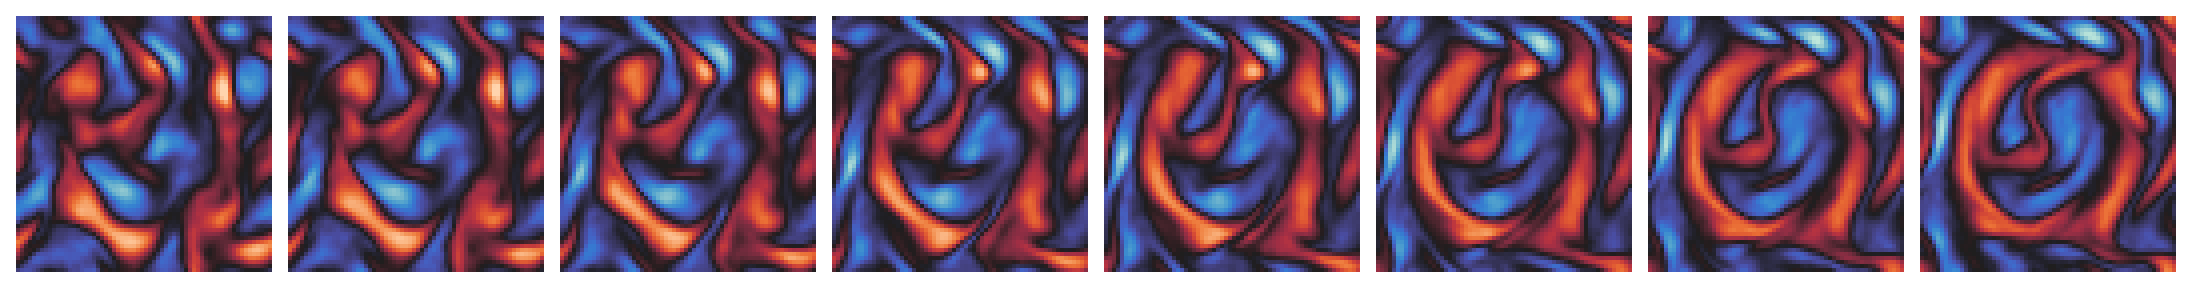

In [ ]:
x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_circle.png')
draw(w, zoom=4)

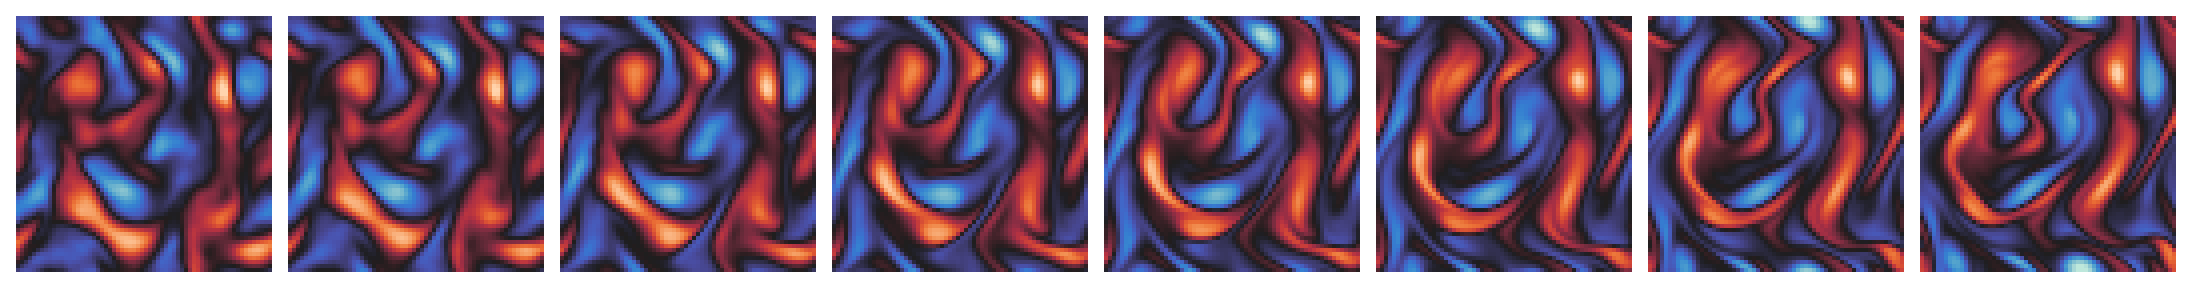

In [ ]:
y0 = chain.upsample(x[0], 4)
y = chain.trajectory(y0, length=7)
y = torch.cat((y0[None], y))
y = chain.coarsen(y, 4)

w = chain.vorticity(y)

draw(w, zoom=4).save('x_circle_sim.png')
draw(w, zoom=4)

## Assimilation

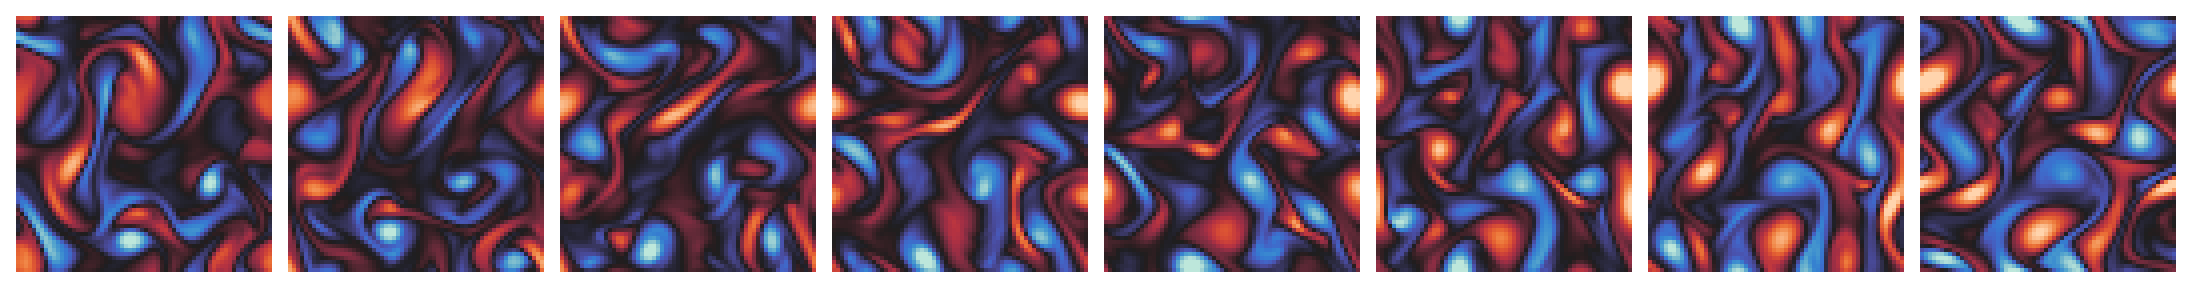

In [ ]:
with h5py.File(PATH / '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments/kolmogorov/data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][1, :29])

w = chain.vorticity(x_star[::4])

draw(w, zoom=4).save('x_star_assim.png')
draw(w, zoom=4)

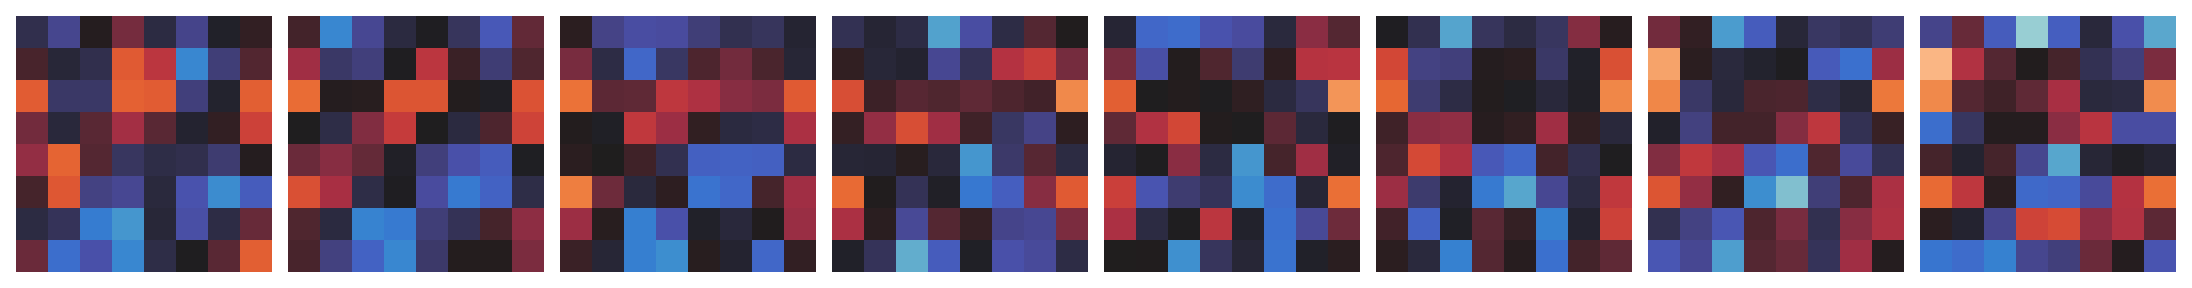

In [ ]:
def A(x):
    return chain.coarsen(x[..., ::4, :, :, :], 8)

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(y_star) / 2.5
w = chain.upsample(w, 2, mode='nearest')

draw(w, pad=1, zoom=16).save('y_star_assim.png')
draw(w, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 256/256 [41:35<00:00,  9.75s/it]


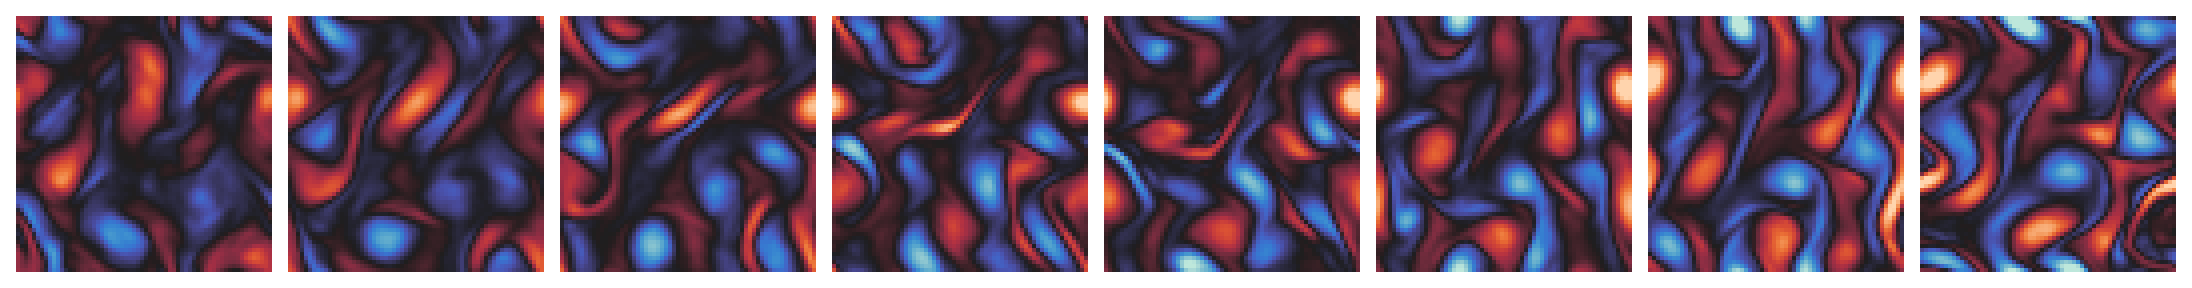

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
# ).cuda()
)

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_sda_assim.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()  # should be ≈ 0.1

tensor(0.1212)

100%|█████████████████████████████████████████████████| 256/256 [41:23<00:00,  9.70s/it]


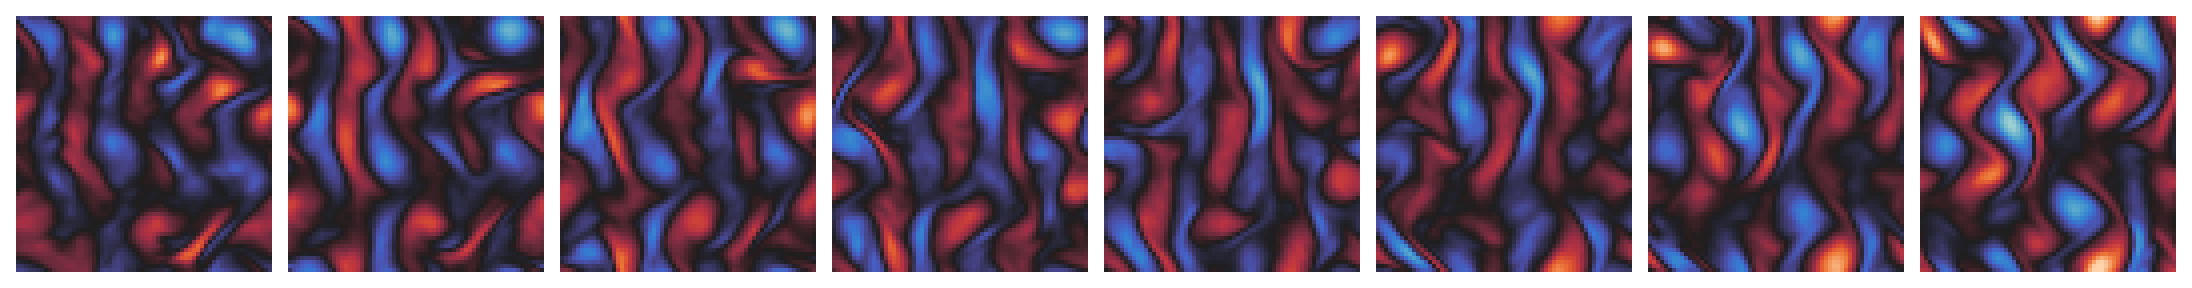

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
        # sde=score,
    ),
    shape=x_star.shape,
# ).cuda()
)

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
# x = sde.sample(steps=256, corrections=1, tau=0.5).to('cpu')
w = chain.vorticity(x[::4])

draw(w, zoom=4).save('x_dps_assim.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()

tensor(0.8142)

## Extrapolation

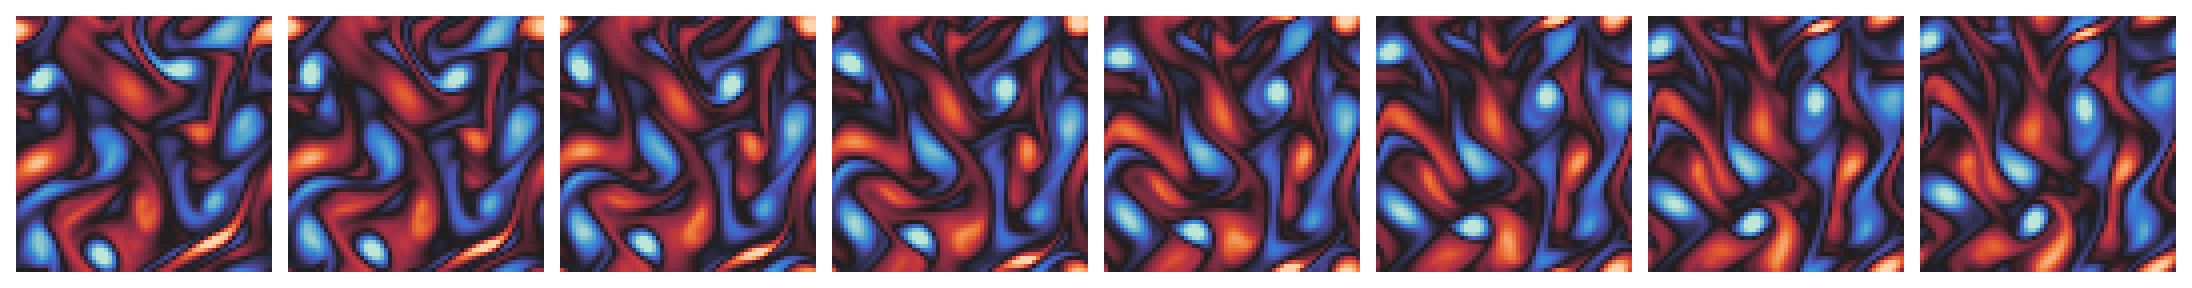

In [ ]:
with h5py.File(PATH / '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments/kolmogorov/data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][0, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_extra.png')
draw(w, zoom=4)

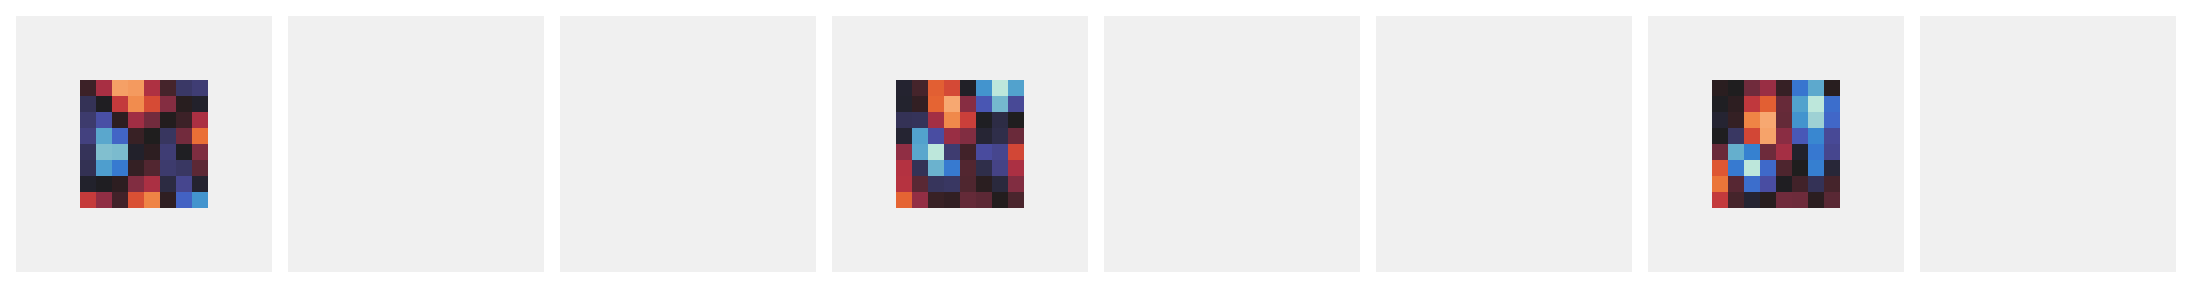

In [ ]:
def A(x):
    return chain.coarsen(x, 4)[..., ::3, :, 4:12, 4:12]

y_star = torch.normal(A(x_star), 0.01)

w = chain.vorticity(chain.coarsen(x_star, 4)) / 2

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 4:12, 4:12] = True

draw(w, mask, pad=1, zoom=16).save('y_star_extra.png')
draw(w, mask, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 256/256 [08:42<00:00,  2.04s/it]


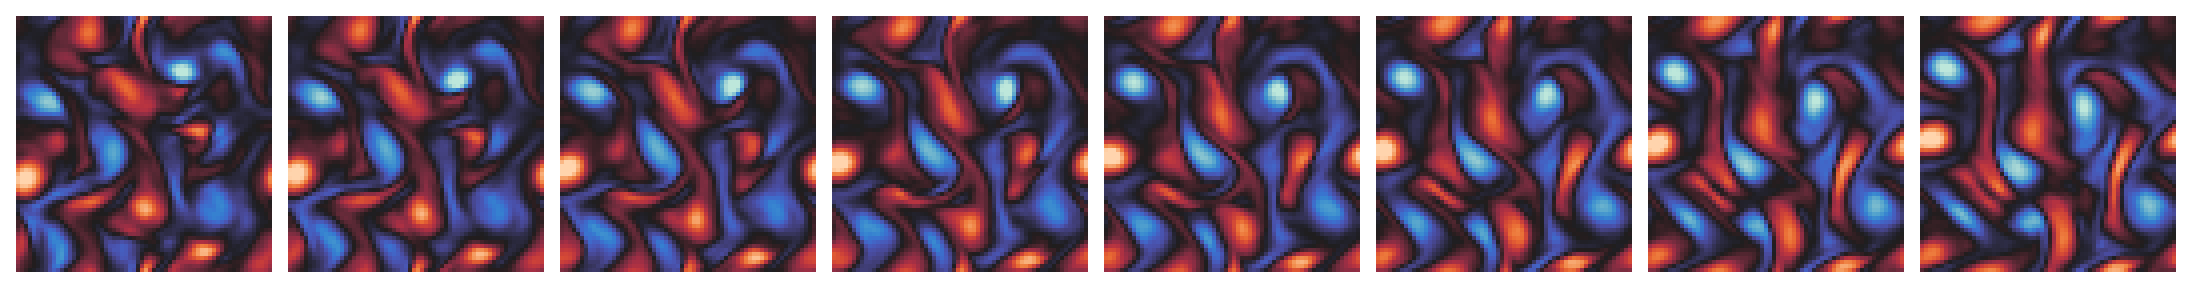

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.01,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
# ).cuda()
)

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_extra.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()  # should be ≈ 0.01

tensor(0.0128)

100%|█████████████████████████████████████████████████| 256/256 [09:19<00:00,  2.18s/it]


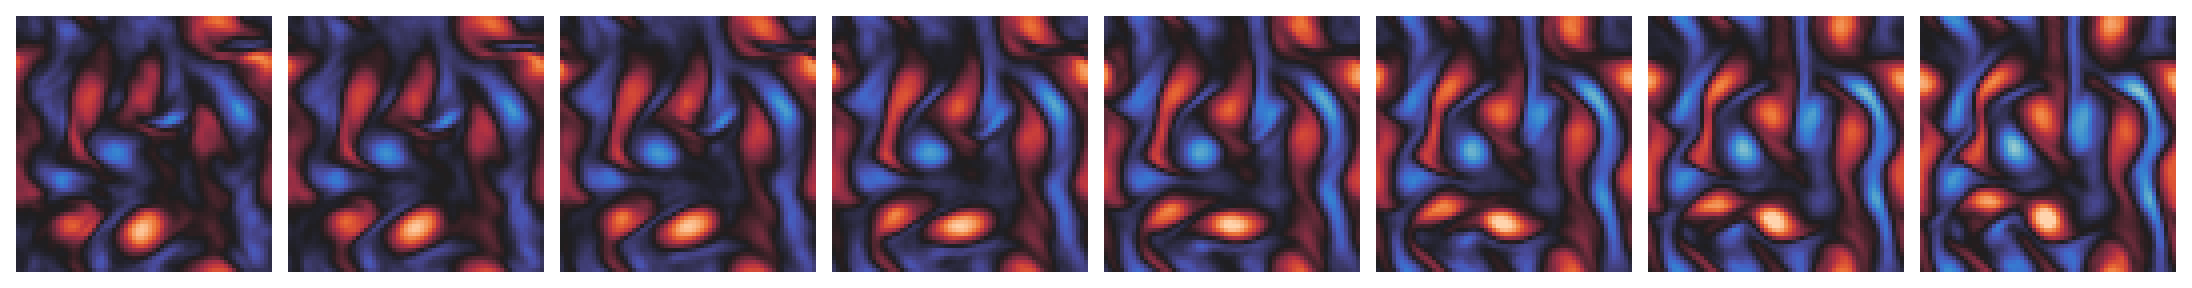

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
# ).cuda()
)

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_extra.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()

tensor(0.6871)

## Non-linear observation process

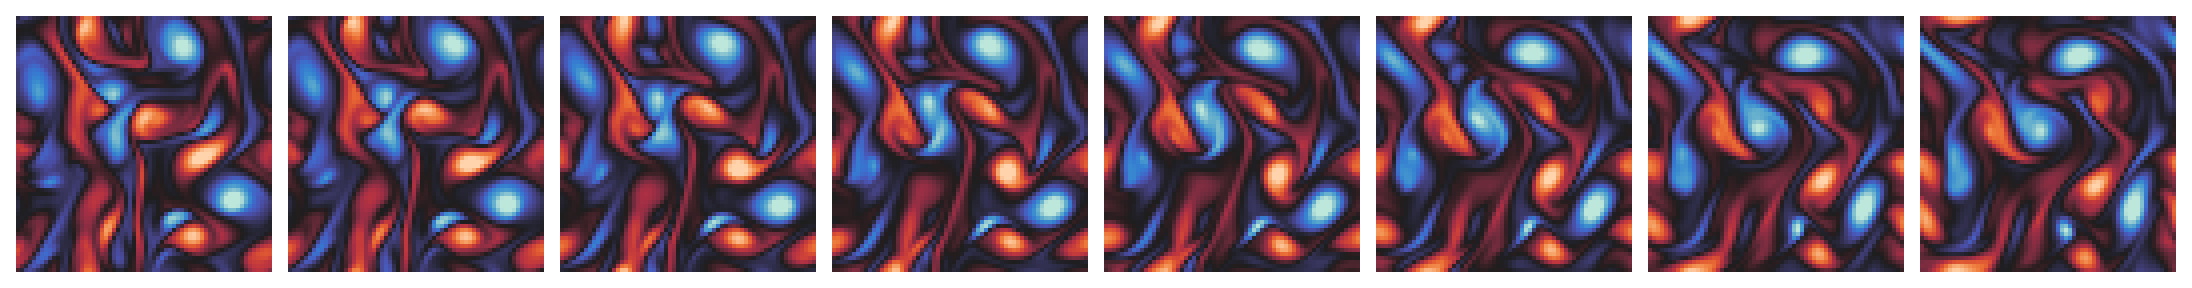

In [ ]:
with h5py.File(PATH / '/content/drive/MyDrive/FISE 3A/UE_F_Computational Imaging/Project/sda-master/experiments/kolmogorov/data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][2, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_saturation.png')
draw(w, zoom=4)

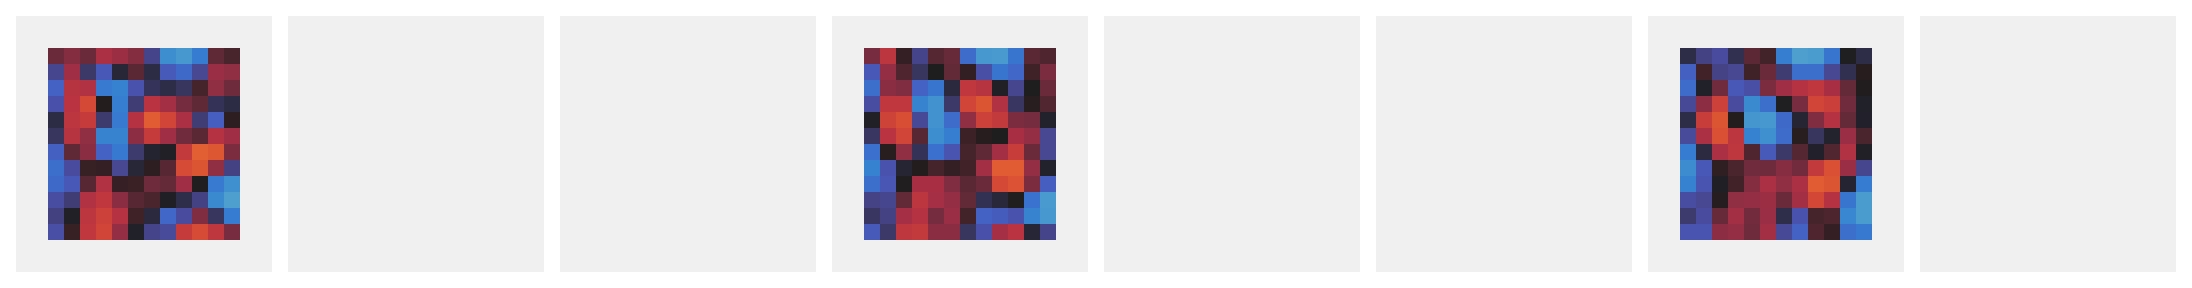

In [ ]:
def A(x):
    x = chain.coarsen(x[..., ::3, :, :, :], 4)
    w = chain.vorticity(x)
    w = w / (1 + abs(w))

    return w[..., 2:14, 2:14]

y_star = torch.normal(A(x_star), 0.05)

w = chain.vorticity(chain.coarsen(x_star, 4))
w = w / (1 + abs(w))

mask = np.zeros((8, 16, 16), dtype=bool)
mask[::3, 2:14, 2:14] = True

draw(w, mask, pad=1, zoom=16).save('y_star_saturation.png')
draw(w, mask, pad=1, zoom=16)

100%|█████████████████████████████████████████████████| 512/512 [17:47<00:00,  2.08s/it]


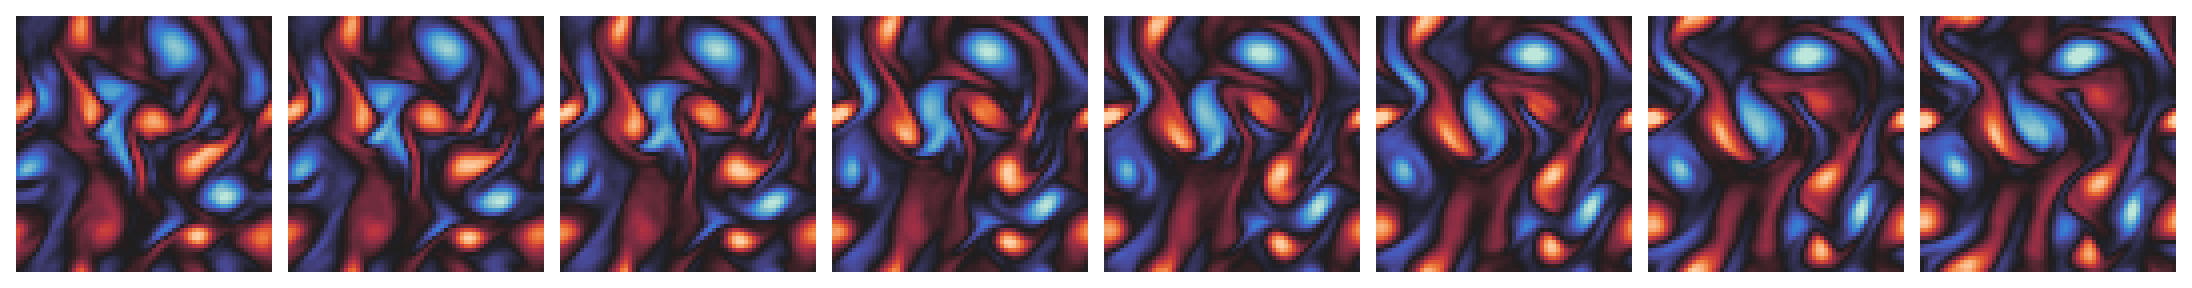

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.05,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
# ).cuda()
)

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_saturation.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=512, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_saturation.png')
draw(w, zoom=4)

In [ ]:
(A(x) - y_star).std()

## Subsampling

In [ ]:
with h5py.File(PATH / 'data/test.h5') as f:
    x_star = torch.from_numpy(f['x'][3, :8])

w = chain.vorticity(x_star)

draw(w, zoom=4).save('x_star_sub.png')
draw(w, zoom=4)

In [ ]:
def A(x):
    return x[..., ::2, ::2]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::2, ::2] = True

draw(w, mask, zoom=4).save('y_star_sub_2.png')
draw(w, mask, zoom=4)

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_2.png')
draw(w, zoom=4)

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_2.png')
draw(w, zoom=4)

In [ ]:
def A(x):
    return x[..., ::4, ::4]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::4, ::4] = True

draw(w, mask, zoom=4).save('y_star_sub_4.png')
draw(w, mask, zoom=4)

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_4.png')
draw(w, zoom=4)

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_4.png')
draw(w, zoom=4)

In [ ]:
def A(x):
    return x[..., ::8, ::8]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::8, ::8] = True

draw(w, mask, zoom=4).save('y_star_sub_8.png')
draw(w, mask, zoom=4)

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_8.png')
draw(w, zoom=4)

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_8.png')
draw(w, zoom=4)

In [ ]:
def A(x):
    return x[..., ::16, ::16]

y_star = torch.normal(A(x_star), 0.1)

w = chain.vorticity(x_star) / 2

mask = np.zeros((8, 64, 64), dtype=bool)
mask[:, ::16, ::16] = True

draw(w, mask, zoom=4).save('y_star_sub_16.png')
draw(w, mask, zoom=4)

In [ ]:
sde = VPSDE(
    GaussianScore(
        y_star,
        A=A,
        std=0.1,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_sda_sub_16.png')
draw(w, zoom=4)

In [ ]:
sde = VPSDE(
    DPSGaussianScore(
        y_star,
        A=A,
        zeta=1.0,
        sde=VPSDE(score, shape=()),
    ),
    shape=x_star.shape,
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x)

draw(w, zoom=4).save('x_dps_sub_16.png')
draw(w, zoom=4)

## Loop

In [ ]:
sde = VPSDE(
    GaussianScore(
        torch.zeros(2, 64, 64),
        A=lambda x: x[:, 0] - x[:, -1],
        std=0.01,
        sde=VPSDE(score, shape=()),
        gamma=0.1,
    ),
    shape=(127, 2, 64, 64),
).cuda()

x = sde.sample(steps=256, corrections=1, tau=0.5).cpu()
w = chain.vorticity(x[::2])

draw(w.reshape(8, 8, 64, 64), zoom=4).save('x_loop.png')
draw(w.reshape(8, 8, 64, 64), zoom=4)